In [1]:
path_to_db = '/Users/naziaignatenko/Public/PRACTICUM_YANDEX/Projects/diplom/data/ds-plus-final.db'

import os
import pandas as pd
from sqlalchemy import create_engine

#path_to_db = 'ds-plus-final.db'
#engine = create_engine(f'sqlite:///{path_to_db}', echo=False) 

In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import phik

from phik.report import plot_correlation_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.utils.class_weight import compute_sample_weight

from xgboost import XGBClassifier

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from sklearn.metrics import accuracy_score, roc_auc_score


In [3]:
RANDOM_STATE = 160225

# 1. Загрузка таблиц

In [4]:
# Инициация связи с SQLite базой данных
conn = sqlite3.connect(path_to_db)

# Получаем список всех таблиц, присутствующих в базе данных
query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql(query, conn)

# Печатаем названия таблиц
print("Tables in the database:")
print(tables)

# Загружаем каждую таблицу Pandas DataFrame
data_dict = {}
for table in tables['name']:
    data_dict[table] = pd.read_sql(f"SELECT * FROM {table}", conn)

# Завершение связи
conn.close()

Tables in the database:
              name
0         data_arc
1        data_bulk
2   data_bulk_time
3   data_wire_time
4         contract
5         personal
6            phone
7         internet
8         data_gas
9        data_temp
10       data_wire


In [5]:
print(data_dict.keys())

dict_keys(['data_arc', 'data_bulk', 'data_bulk_time', 'data_wire_time', 'contract', 'personal', 'phone', 'internet', 'data_gas', 'data_temp', 'data_wire'])


#### База данных содержит таблицы двух проектов. Выберем только те таблицы, которые относятся к пректу "Телеком"

# 2. Проведение исследовательского анализа и предобработка данных

## Анализ исходных данных

In [6]:
contract_df = data_dict['contract'] 
contract_df.head(5) 

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.3,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.7,353.5


In [7]:
contract_df = contract_df.rename(columns= {'customerID': 'CustomerID'})

In [8]:
contract_df.head()

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.3,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.7,353.5


In [9]:
personal_df = data_dict['personal']  
personal_df.head() 

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [10]:
personal_df = personal_df.rename(columns = {'customerID': 'CustomerID', 'gender': 'Gender'})

In [11]:
phone_df = data_dict['phone']  
phone_df.head() 

,CustomerId,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [12]:
phone_df = phone_df.rename(columns = {'CustomerId': 'CustomerID'})

In [13]:
internet_df = data_dict['internet']  
internet_df.head() 

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [14]:
internet_df = internet_df.rename(columns = {'customerID': 'CustomerID'})

## Вывод:
1. Присутствуют все заявленные таблицы
2. Таблицы содержат данные
3. Таблицы загружены в формате pandas DataFrame

### Исследовательский анализ данных и обработка аномалий в каждом датафрейме

#### Датафрейм contract_df

In [15]:
contract_df.sample(5) 

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
5425,4998-IKFSE,2017-08-01,No,Month-to-month,No,Electronic check,100.45,3013.5
6757,5294-CDGWY,2015-09-01,2019-09-01,One year,No,Electronic check,59.3,3102.58
2554,5843-TTHGI,2018-08-01,No,Month-to-month,Yes,Mailed check,50.0,900.0
6718,8676-TRMJS,2019-10-01,No,Month-to-month,No,Mailed check,75.0,306.0
812,8098-TDCBU,2016-08-01,No,Two year,No,Electronic check,25.25,1166.55


In [16]:
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   CustomerID        7043 non-null   object
 1   BeginDate         7043 non-null   object
 2   EndDate           7043 non-null   object
 3   Type              7043 non-null   object
 4   PaperlessBilling  7043 non-null   object
 5   PaymentMethod     7043 non-null   object
 6   MonthlyCharges    7043 non-null   object
 7   TotalCharges      7043 non-null   object
dtypes: object(8)
memory usage: 440.3+ KB


In [17]:
contract_df["EndDate"] = contract_df["EndDate"].replace("No", pd.NaT) 
contract_df["TotalCharges"] = contract_df["TotalCharges"].replace(" ", "0") 
contract_df = contract_df.astype({
    "MonthlyCharges": "float",
    "TotalCharges": "float",
    "BeginDate": "datetime64[ns]",
    "EndDate": "datetime64[ns]"
})

In [18]:
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1101 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


Cтолбец EndDate имеет очень много незаполненных строк (действующий договор), в остальных столбцах пропуски отсутствуют

In [19]:
contract_df.describe()

,BeginDate,EndDate,MonthlyCharges,TotalCharges
count,7043,1101,7043.000000,7043.000000
mean,2017-04-30 13:01:50.918642688,2018-03-12 18:21:15.204359680,64.761692,2115.312885
min,2013-10-01 00:00:00,2014-06-01 00:00:00,18.250000,0.000000
25%,2015-06-01 00:00:00,2017-05-01 00:00:00,35.500000,436.750000
50%,2017-09-01 00:00:00,2018-06-01 00:00:00,70.350000,1343.350000
75%,2019-04-01 00:00:00,2019-04-01 00:00:00,89.850000,3236.690000
max,2020-02-01 00:00:00,2020-01-01 00:00:00,118.750000,9221.380000
std,NaN,NaN,30.090047,2112.742814


In [20]:
contract_df.shape

(7043, 8)

##### Проверка наличия дубликатов

In [21]:
contract_df.duplicated().sum()

np.int64(0)

In [22]:
contract_df.duplicated(subset=["CustomerID"]).sum()

np.int64(0)

Дубликатов нет

In [23]:
# Вывод уникальных значений для столбцов 'Type' 'PaperlessBilling' 'PaymentMethod'
for column in contract_df.columns[3:6]:
    print(f"Уникальные значения в стобце {column}:")
    print(contract_df[column].unique())
    print()

Уникальные значения в стобце Type:
['Month-to-month' 'One year' 'Two year']

Уникальные значения в стобце PaperlessBilling:
['Yes' 'No']

Уникальные значения в стобце PaymentMethod:
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']



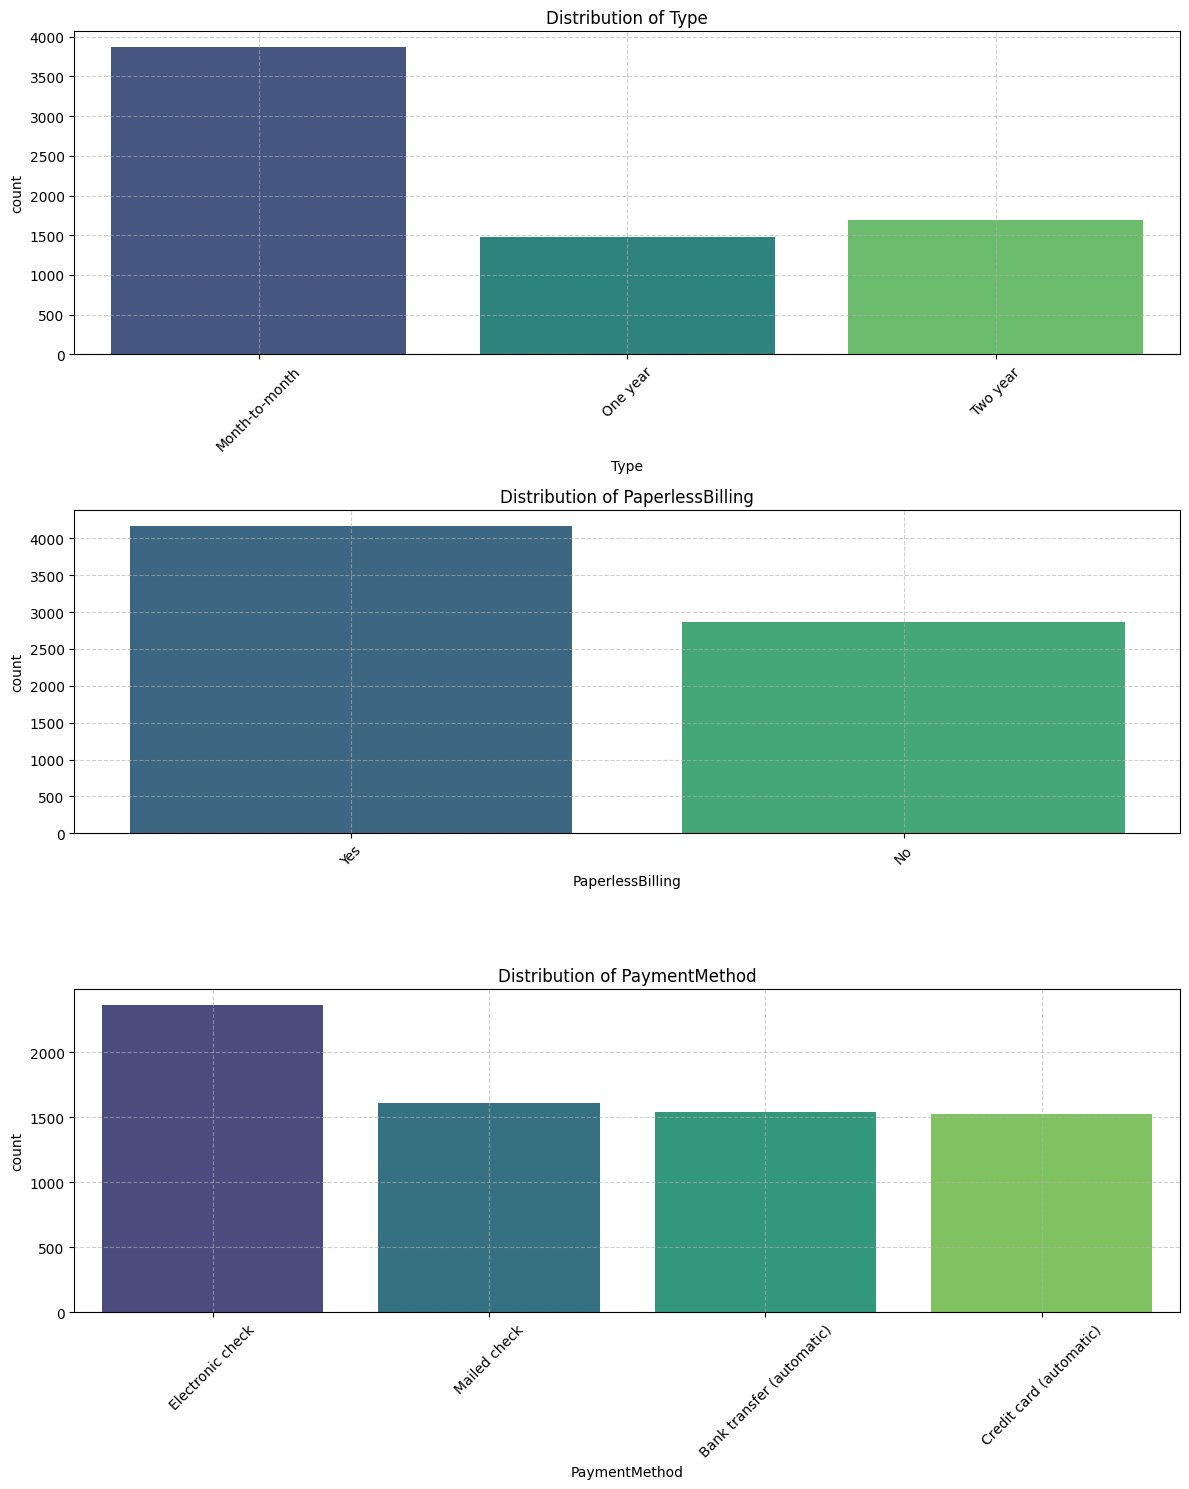

In [24]:
# Построим бар диаграммы для столбцов 'Type' 'PaperlessBilling' 'PaymentMethod'
columns_to_plot = contract_df.columns[3:6]

# Задаем размер графика
plt.figure(figsize=(12, 15))

for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(len(columns_to_plot), 1, i)
    sns.countplot(data=contract_df, x=col, hue=col, legend=False, palette="viridis") 
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45) 
    plt.grid(True, linestyle="--", alpha=0.6)

# Вывод графиков
plt.tight_layout()
plt.show()

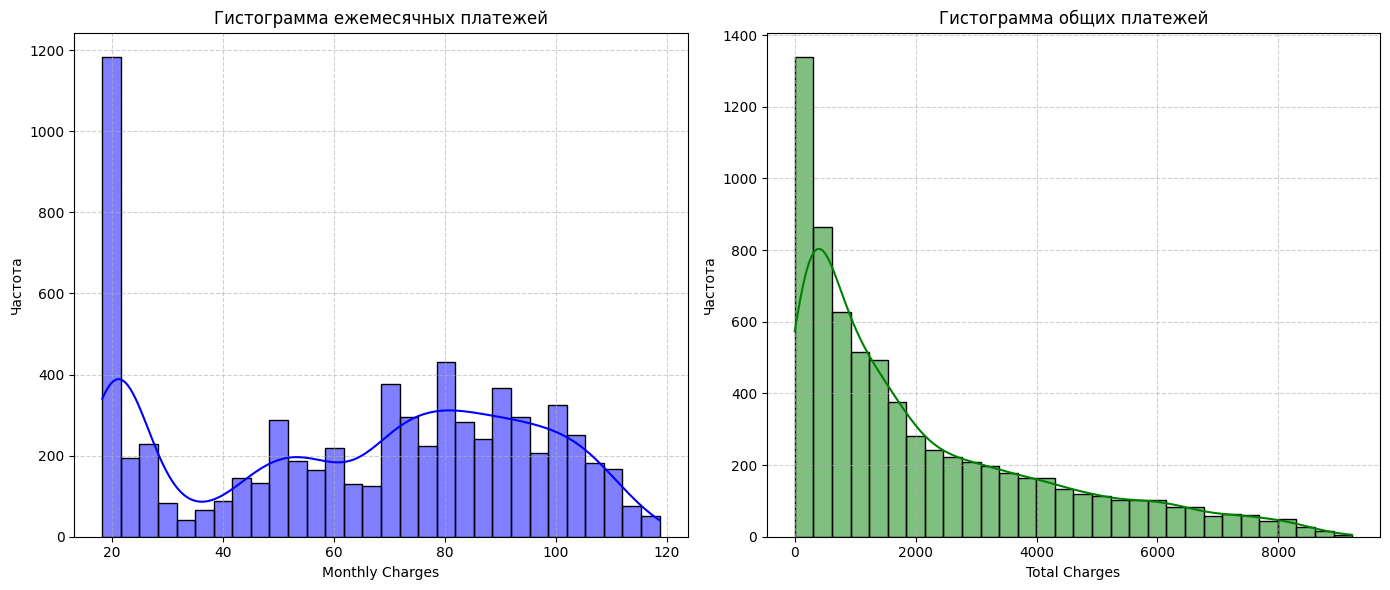

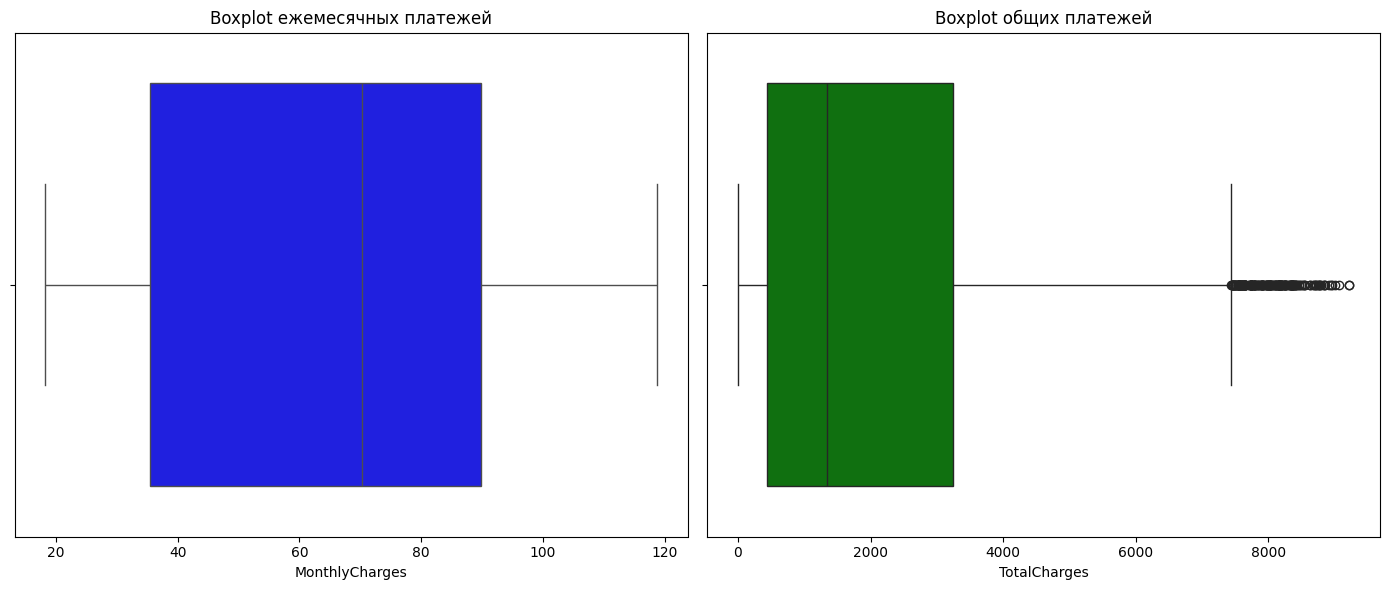

In [25]:
# Построим гистограммы и ящик с усами для столбцов 'MonthlyCharges' 'TotalCharges' 
# Создаем фиг. для гистограмм
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Гистограмма для 'MonthlyCharges'
sns.histplot(contract_df["MonthlyCharges"], bins=30, kde=True, color="blue", ax=axes[0])
axes[0].set_title("Гистограмма ежемесячных платежей")
axes[0].set_xlabel("Monthly Charges")
axes[0].set_ylabel("Частота")
axes[0].grid(True, linestyle="--", alpha=0.6)

# Гистограмма для 'TotalCharges'
sns.histplot(contract_df["TotalCharges"], bins=30, kde=True, color="green", ax=axes[1])
axes[1].set_title("Гистограмма общих платежей")
axes[1].set_xlabel("Total Charges")
axes[1].set_ylabel("Частота")
axes[1].grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

# Создаем новую фиг. для boxplot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot для 'MonthlyCharges'
sns.boxplot(x=contract_df["MonthlyCharges"], color="blue", ax=axes[0])
axes[0].set_title("Boxplot ежемесячных платежей")

# Boxplot для 'TotalCharges'
sns.boxplot(x=contract_df["TotalCharges"], color="green", ax=axes[1])
axes[1].set_title("Boxplot общих платежей")

plt.tight_layout()
plt.show()

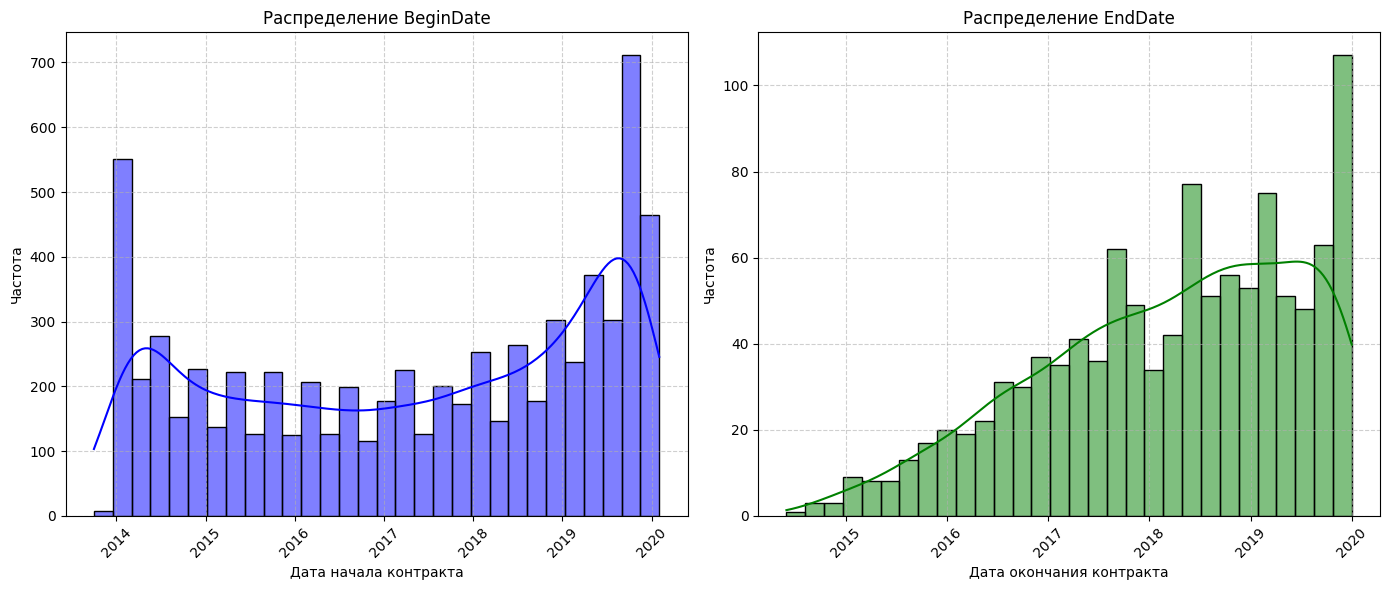

In [26]:
# Построим гистограммы для столбцов с датами "BeginDate" и "EndDate"
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(contract_df["BeginDate"], bins=30, kde=True, color="blue")
plt.title("Распределение BeginDate")
plt.xlabel("Дата начала контракта")
plt.ylabel("Частота")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)

plt.subplot(1, 2, 2)
sns.histplot(contract_df["EndDate"], bins=30, kde=True, color="green")
plt.title("Распределение EndDate")
plt.xlabel("Дата окончания контракта")
plt.ylabel("Частота")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

#### Замена отсутствующих данных в "EndDate"

Предположим, что No означает, что контракт еще действует, поэтому для дальнейшей работы заменим No на самую последнюю дату в столбце "EndDate"

### Создадим новый столбец "Churn" со значениями 1 - ушедшие клиенты, 0 - оставшиеся клиенты, который будем использовать в качестве целевого признака

In [27]:
contract_df["Churn"] = np.where(contract_df["EndDate"].isna(), 0, 1)
contract_df.sample(5)

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
4293,2114-MGINA,2018-09-01,NaT,Month-to-month,Yes,Mailed check,89.80,1526.60,0
808,4289-DTDKW,2016-08-01,2019-05-01,Month-to-month,Yes,Electronic check,101.30,3643.76,1
3421,6719-FGEDO,2014-02-01,NaT,Two year,Yes,Bank transfer (automatic),97.00,6984.00,0
119,9445-ZUEQE,2017-11-01,NaT,Month-to-month,Yes,Credit card (automatic),85.20,2346.41,0
6641,2810-FTLEM,2018-09-01,NaT,Month-to-month,Yes,Electronic check,50.15,861.08,0


Churn
0    0.843675
1    0.156325
Name: proportion, dtype: float64
Churn
0    5942
1    1101
Name: count, dtype: int64


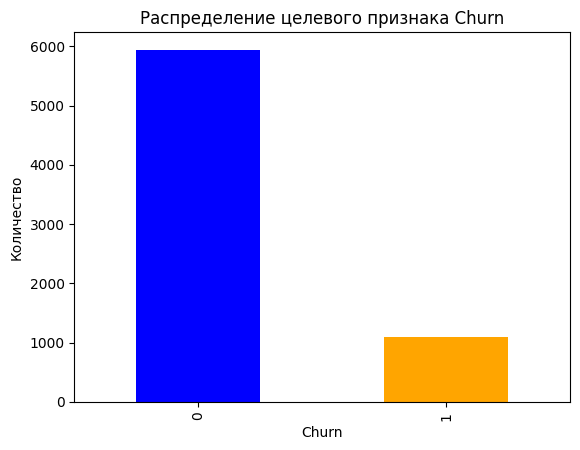

In [28]:
# Посмотрим на количество классов
print(contract_df["Churn"].value_counts(normalize=True))  # Доля каждого класса
print(contract_df["Churn"].value_counts())  # Количество наблюдений каждого класса

# Визуализируем распределение
contract_df["Churn"].value_counts().plot(kind="bar", color=["blue", "orange"])
plt.xlabel("Churn")
plt.ylabel("Количество")
plt.title("Распределение целевого признака Churn")
plt.show()

#### Для дальнейшей работы с данными в колонке "EndDate" заменим NaT максимальной датой в клонке  "EndDate", поскольку NaT означает наличие действующего договора

In [29]:
# Замена отсутствующих данных в "EndDate"
max_date = contract_df["EndDate"].max()
contract_df["EndDate"] = contract_df["EndDate"].fillna(max_date)

#### Создадим новый признак  "ContractDuration"

In [30]:
# Преобразуем даты в to_datetime
contract_df["BeginDate"] = pd.to_datetime(contract_df["BeginDate"], errors="coerce")
contract_df["EndDate"] = pd.to_datetime(contract_df["EndDate"], errors="coerce")

# Вычисляем длительность контракта в днях
contract_df["ContractDuration"] = (contract_df["EndDate"] - contract_df["BeginDate"]).dt.days

In [31]:
# Категоризуем длительность контракта 
def categorize_duration(days):
    if days < 180:
        return "Short-term (0-6 months)"
    elif days < 365:
        return "Medium-term (6-12 months)"
    elif days < 730:
        return "Long-term (1-2 years)"
    else:
        return "Very long-term (2+ years)"

contract_df["ContractCategory"] = contract_df["ContractDuration"].apply(categorize_duration)

#### Создадим новый категориальный признак "ContractCategory" с классами длительности договора : 0-6 месяцев (короткий); 6-12 месяцев (средний), 1-2 года (длительный) и больше 2 лет (очень длинный)

In [32]:
print(f"Максимальная дата в данных: {max_date}")
contract_df[["BeginDate", "EndDate", "ContractDuration", "ContractCategory"]].head()
print(contract_df["ContractCategory"].value_counts())  

Максимальная дата в данных: 2020-01-01 00:00:00
ContractCategory
Very long-term (2+ years)    3582
Short-term (0-6 months)      1361
Long-term (1-2 years)        1263
Medium-term (6-12 months)     837
Name: count, dtype: int64


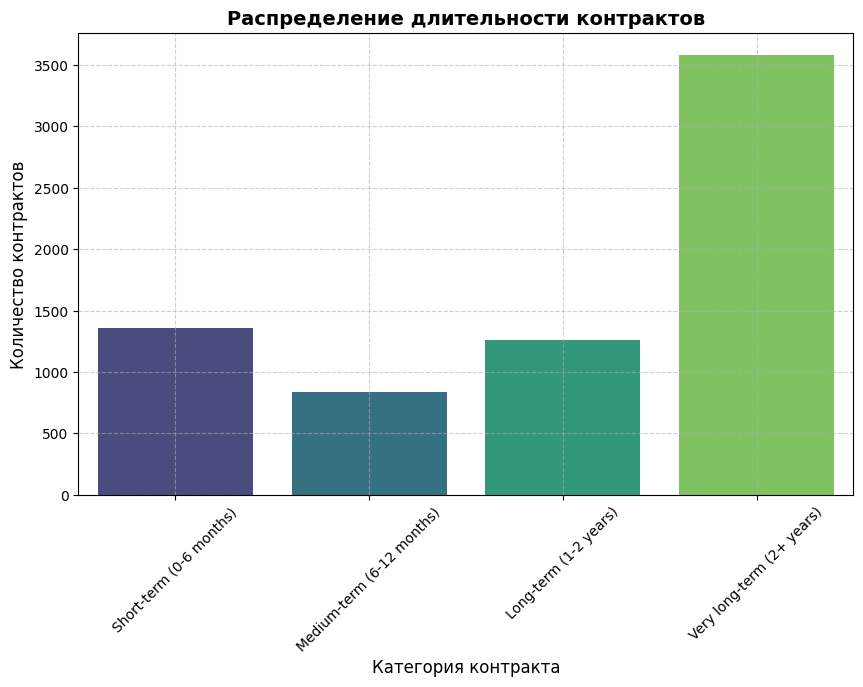

In [33]:
# Определяем порядок категорий
sorted_categories = ["Short-term (0-6 months)", 
                     "Medium-term (6-12 months)", 
                     "Long-term (1-2 years)", 
                     "Very long-term (2+ years)"]
# Указываем порядок категорий в столбце Contract_Category
contract_df["ContractCategory"] = pd.Categorical(
                                    contract_df["ContractCategory"], 
                                    categories=sorted_categories, 
                                    ordered=True)
# Устанавливаем размер фигуры
plt.figure(figsize=(10, 6))

# Создаем бар-диаграмму для категорий контрактов (исправленный код для Seaborn v0.14.0)
sns.countplot(
        data=contract_df, 
        x="ContractCategory", 
        hue="ContractCategory", 
        palette="viridis",
        order=sorted_categories,
        legend=False)

# Настройки заголовка и подписей
plt.title("Распределение длительности контрактов", fontsize=14, fontweight='bold')
plt.xlabel("Категория контракта", fontsize=12)
plt.ylabel("Количество контрактов", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)

# Отображаем график
plt.show()

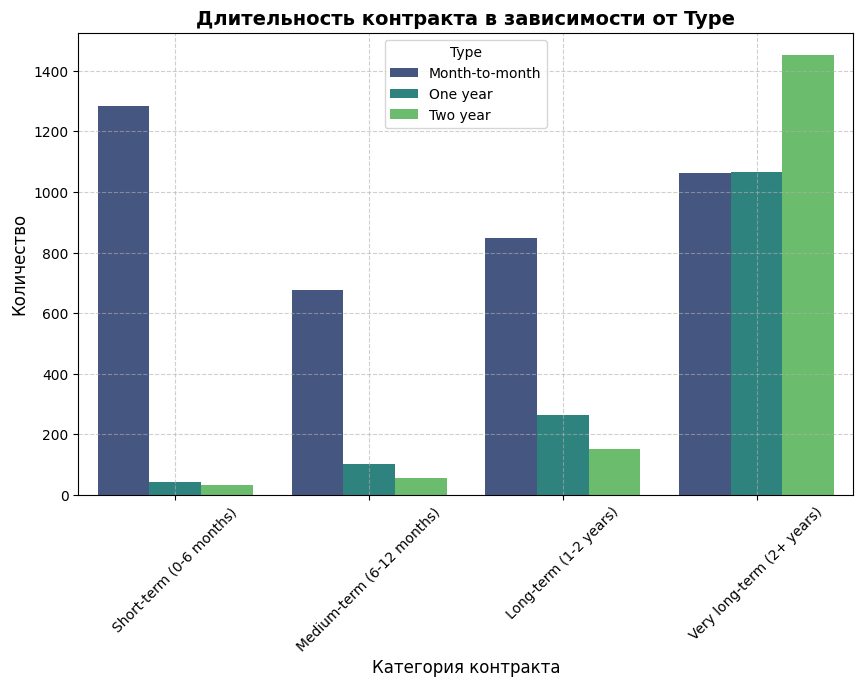

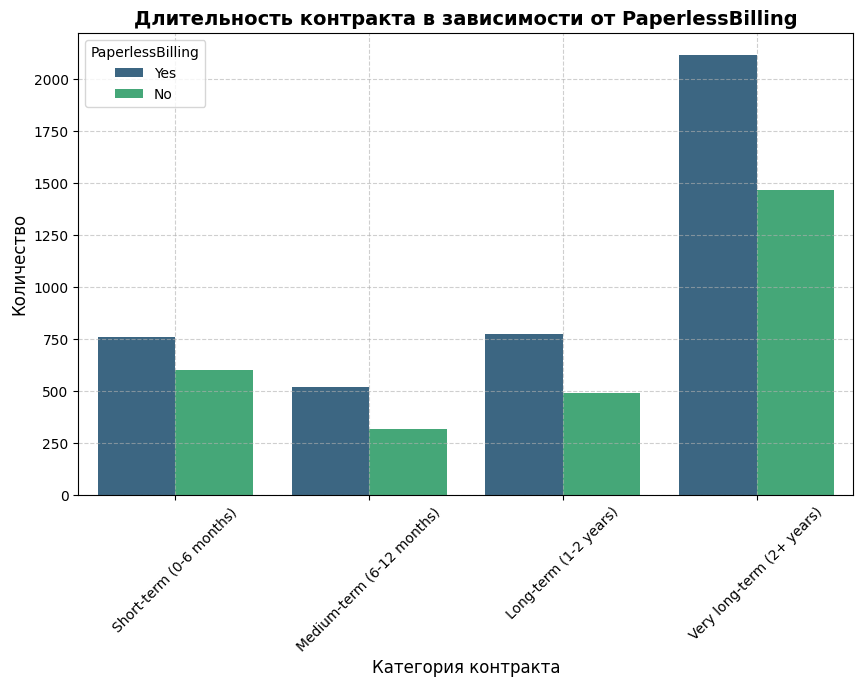

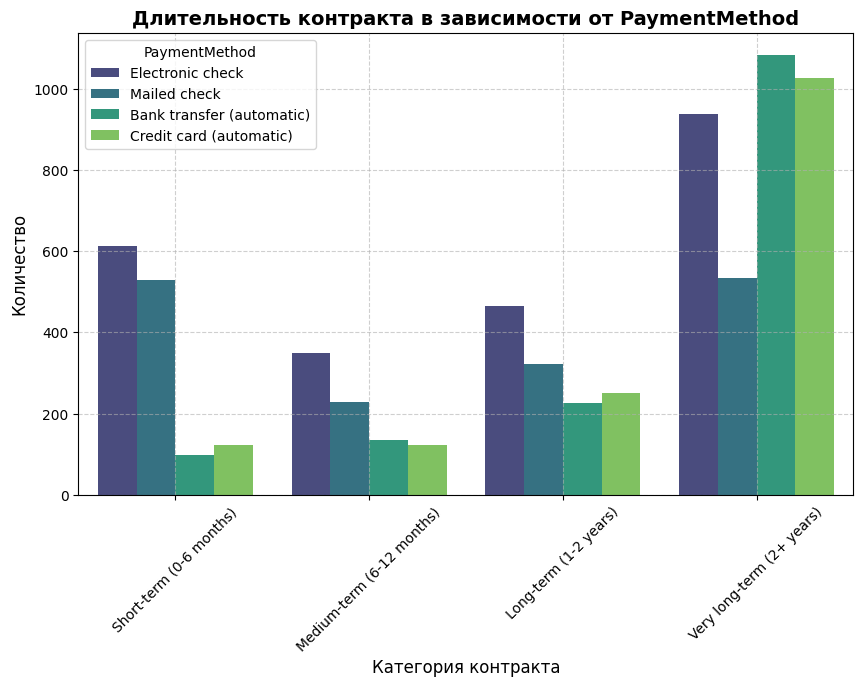

In [34]:
# Фильтрация данных по столбцам
contract_types = ["Type", "PaperlessBilling", "PaymentMethod"]

# Построение отдельных графиков
for contract_type in contract_types:
    plt.figure(figsize=(10, 6))
    sns.countplot(
            data=contract_df, 
            x="ContractCategory", 
            hue=contract_type, 
            palette="viridis", 
            order=sorted_categories)

    # Настройки заголовка и подписей
    plt.title(f"Длительность контракта в зависимости от {contract_type}", fontsize=14, fontweight='bold')
    plt.xlabel("Категория контракта", fontsize=12)
    plt.ylabel("Количество", fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title=contract_type)  # Добавляем легенду
    plt.grid(True, linestyle="--", alpha=0.6)

    # Отображаем график
    plt.show()

### Выводы

#### Датафрейм personal_df

In [35]:
personal_df.sample(5) 

,CustomerID,Gender,SeniorCitizen,Partner,Dependents
6662,6810-VCAEX,Female,0,No,No
3283,1085-LDWAM,Female,0,Yes,Yes
4199,4088-YLDSU,Male,0,Yes,No
2541,0739-UUAJR,Female,0,Yes,Yes
5910,0856-NAOES,Male,0,No,No


In [36]:
personal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerID     7043 non-null   object
 1   Gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   object
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB


In [37]:
personal_df.shape

(7043, 5)

In [38]:
# Вывод уникальных значений
for column in personal_df.columns[1:]:
    print(f"Уникальные значения в стобце {column}:")
    print(personal_df[column].unique())
    print()

Уникальные значения в стобце Gender:
['Female' 'Male']

Уникальные значения в стобце SeniorCitizen:
['0' '1']

Уникальные значения в стобце Partner:
['Yes' 'No']

Уникальные значения в стобце Dependents:
['No' 'Yes']



In [39]:
personal_df = personal_df.astype({"SeniorCitizen": "int64"})

In [40]:
personal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerID     7043 non-null   object
 1   Gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


##### Проверка наличия дубликатов

In [41]:
personal_df.duplicated().sum()

np.int64(0)

In [42]:
personal_df['CustomerID'].duplicated().sum()

np.int64(0)

Дубликаты отсутствуют

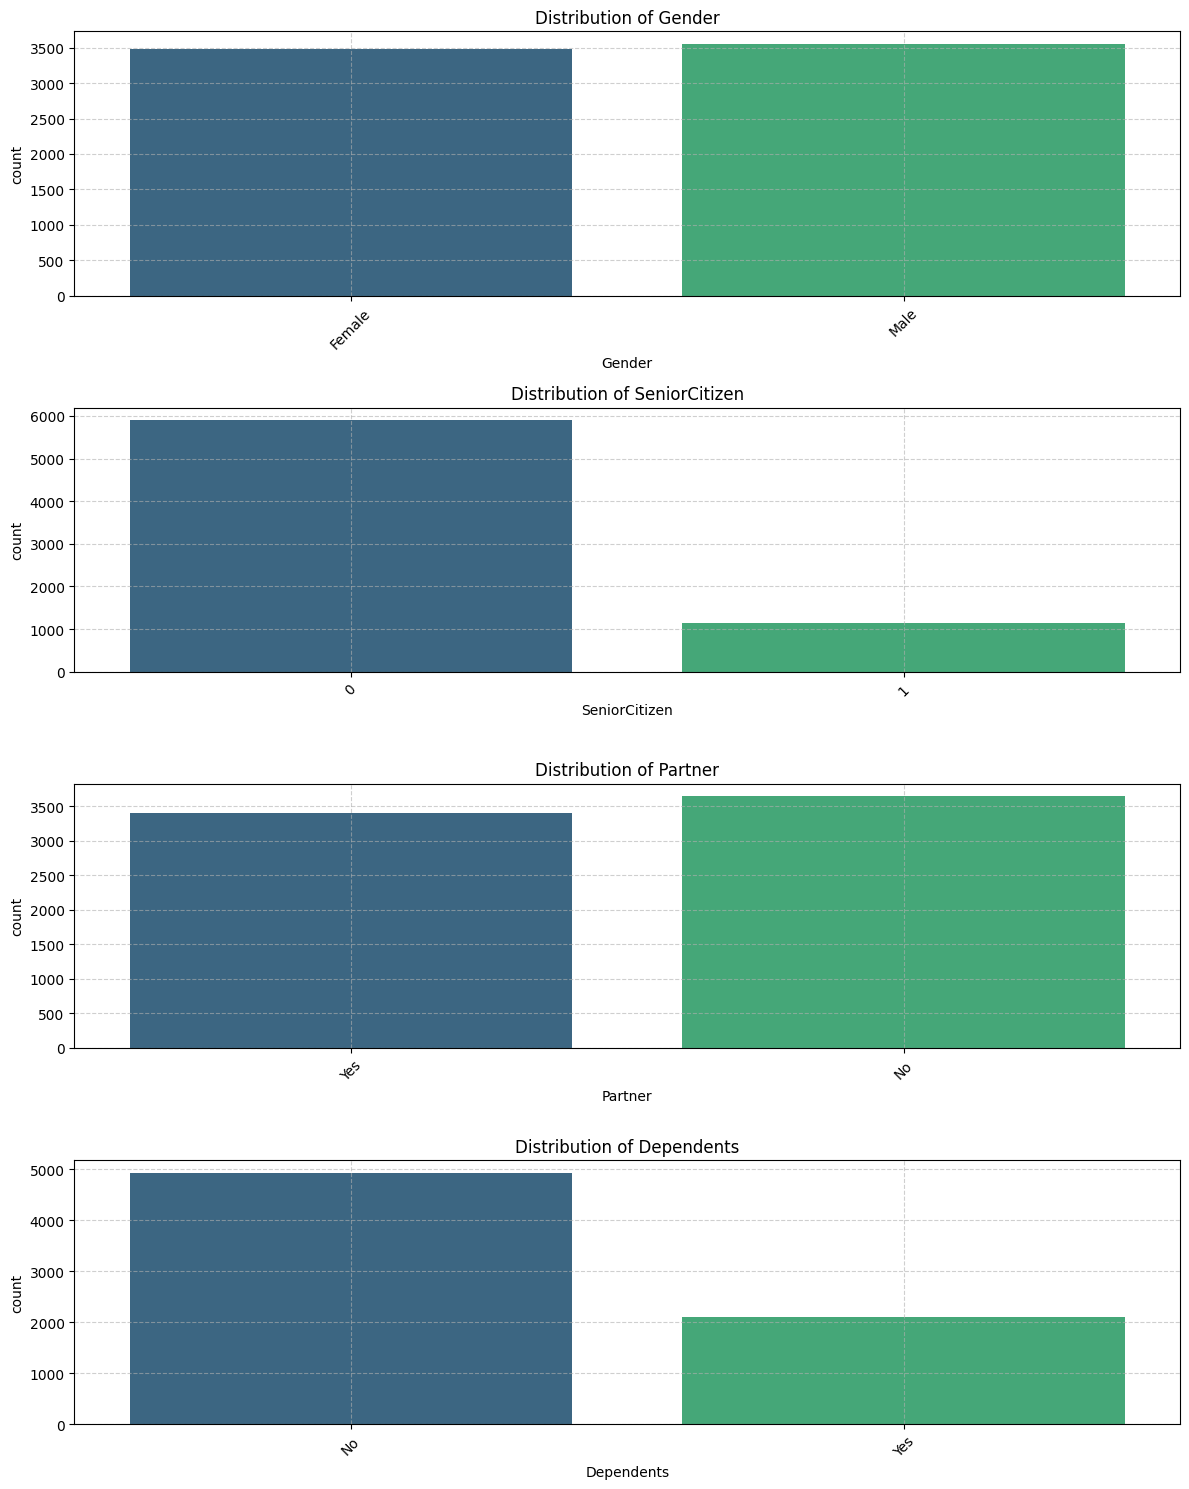

In [43]:
# Построим бар диаграммы для столбцов 'gender', 'SeniorCitizen', 'Partner', 'Dependents'
columns_to_plot = personal_df.columns[1:]

# Задаем размер графика
plt.figure(figsize=(12, 15))

for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(len(columns_to_plot), 1, i)
    sns.countplot(data=personal_df, x=col, hue=col, legend=False, palette="viridis") 
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45) 
    plt.grid(True, linestyle="--", alpha=0.6)

# Вывод графиков
plt.tight_layout()
plt.show()

### Выводы

#### Датафрейм phone_df

In [44]:
phone_df.sample(5)

,CustomerID,MultipleLines
3271,3656-TKRVZ,No
4931,5959-BELXA,Yes
2339,3230-JCNZS,Yes
5825,6608-QQLVK,No
203,0945-TSONX,Yes


In [45]:
phone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [46]:
phone_df.shape

(6361, 2)

##### Проверка наличия дубликатов

In [47]:
phone_df['CustomerID'].duplicated().sum()

np.int64(0)

Дубликаты отсутствуют

In [48]:
phone_df['MultipleLines'].unique()

array(['No', 'Yes'], dtype=object)

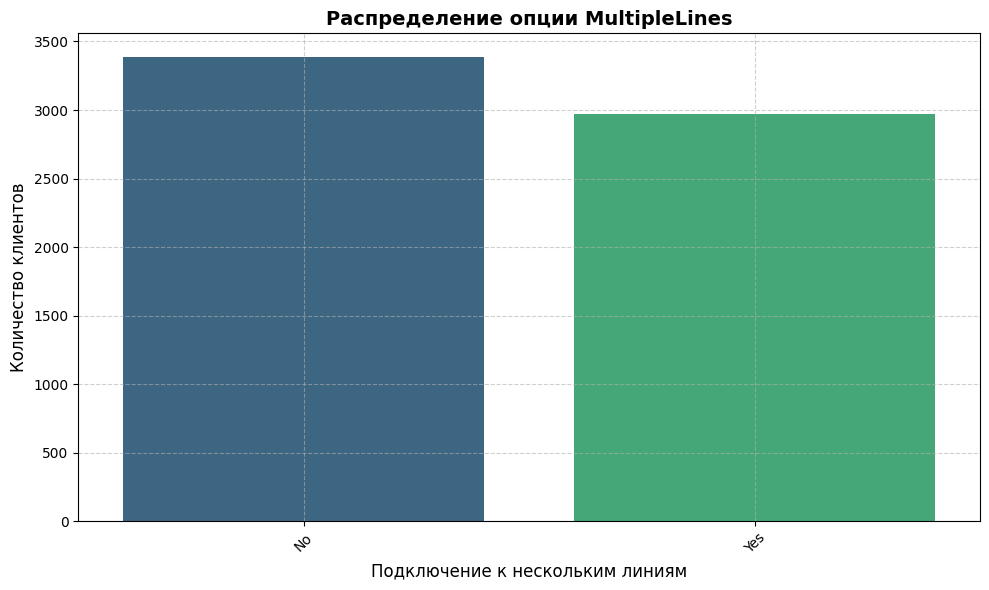

In [49]:
# Построим бар-диаграмму
# Задаем размер графика
plt.figure(figsize=(10, 6))

# Бар-диаграмма для 'MultipleLines' с hue
sns.countplot(data=phone_df, x='MultipleLines', hue='MultipleLines', legend=False, palette="viridis")

# Настройки
plt.title("Распределение опции MultipleLines", fontsize=14, fontweight='bold')
plt.xlabel("Подключение к нескольким линиям", fontsize=12)
plt.ylabel("Количество клиентов", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)

# Отображение графика
plt.tight_layout()
plt.show()

### Выводы

#### Датафрейм internet_df

In [50]:
internet_df.sample(5)

,CustomerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
264,4983-CLMLV,Fiber optic,No,Yes,No,Yes,Yes,Yes
3190,7683-CBDKJ,DSL,Yes,Yes,No,No,Yes,No
639,3009-JWMPU,Fiber optic,No,No,Yes,No,Yes,Yes
1427,5149-QYTTU,Fiber optic,Yes,Yes,Yes,Yes,No,No
4034,7105-BENQF,DSL,Yes,No,Yes,No,No,Yes


In [51]:
internet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   CustomerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [52]:
internet_df.shape

(5517, 8)

##### Проверка наличия дубликатов

In [53]:
internet_df.duplicated().sum()

np.int64(0)

In [54]:
internet_df['CustomerID'].duplicated().sum()

np.int64(0)

Дубликаты отсутствуют

In [55]:
# Вывод уникальных значений
for column in internet_df.columns[1:]:
    print(f"Уникальные значения в стобце {column}:")
    print(internet_df[column].unique())
    print()

Уникальные значения в стобце InternetService:
['DSL' 'Fiber optic']

Уникальные значения в стобце OnlineSecurity:
['No' 'Yes']

Уникальные значения в стобце OnlineBackup:
['Yes' 'No']

Уникальные значения в стобце DeviceProtection:
['No' 'Yes']

Уникальные значения в стобце TechSupport:
['No' 'Yes']

Уникальные значения в стобце StreamingTV:
['No' 'Yes']

Уникальные значения в стобце StreamingMovies:
['No' 'Yes']



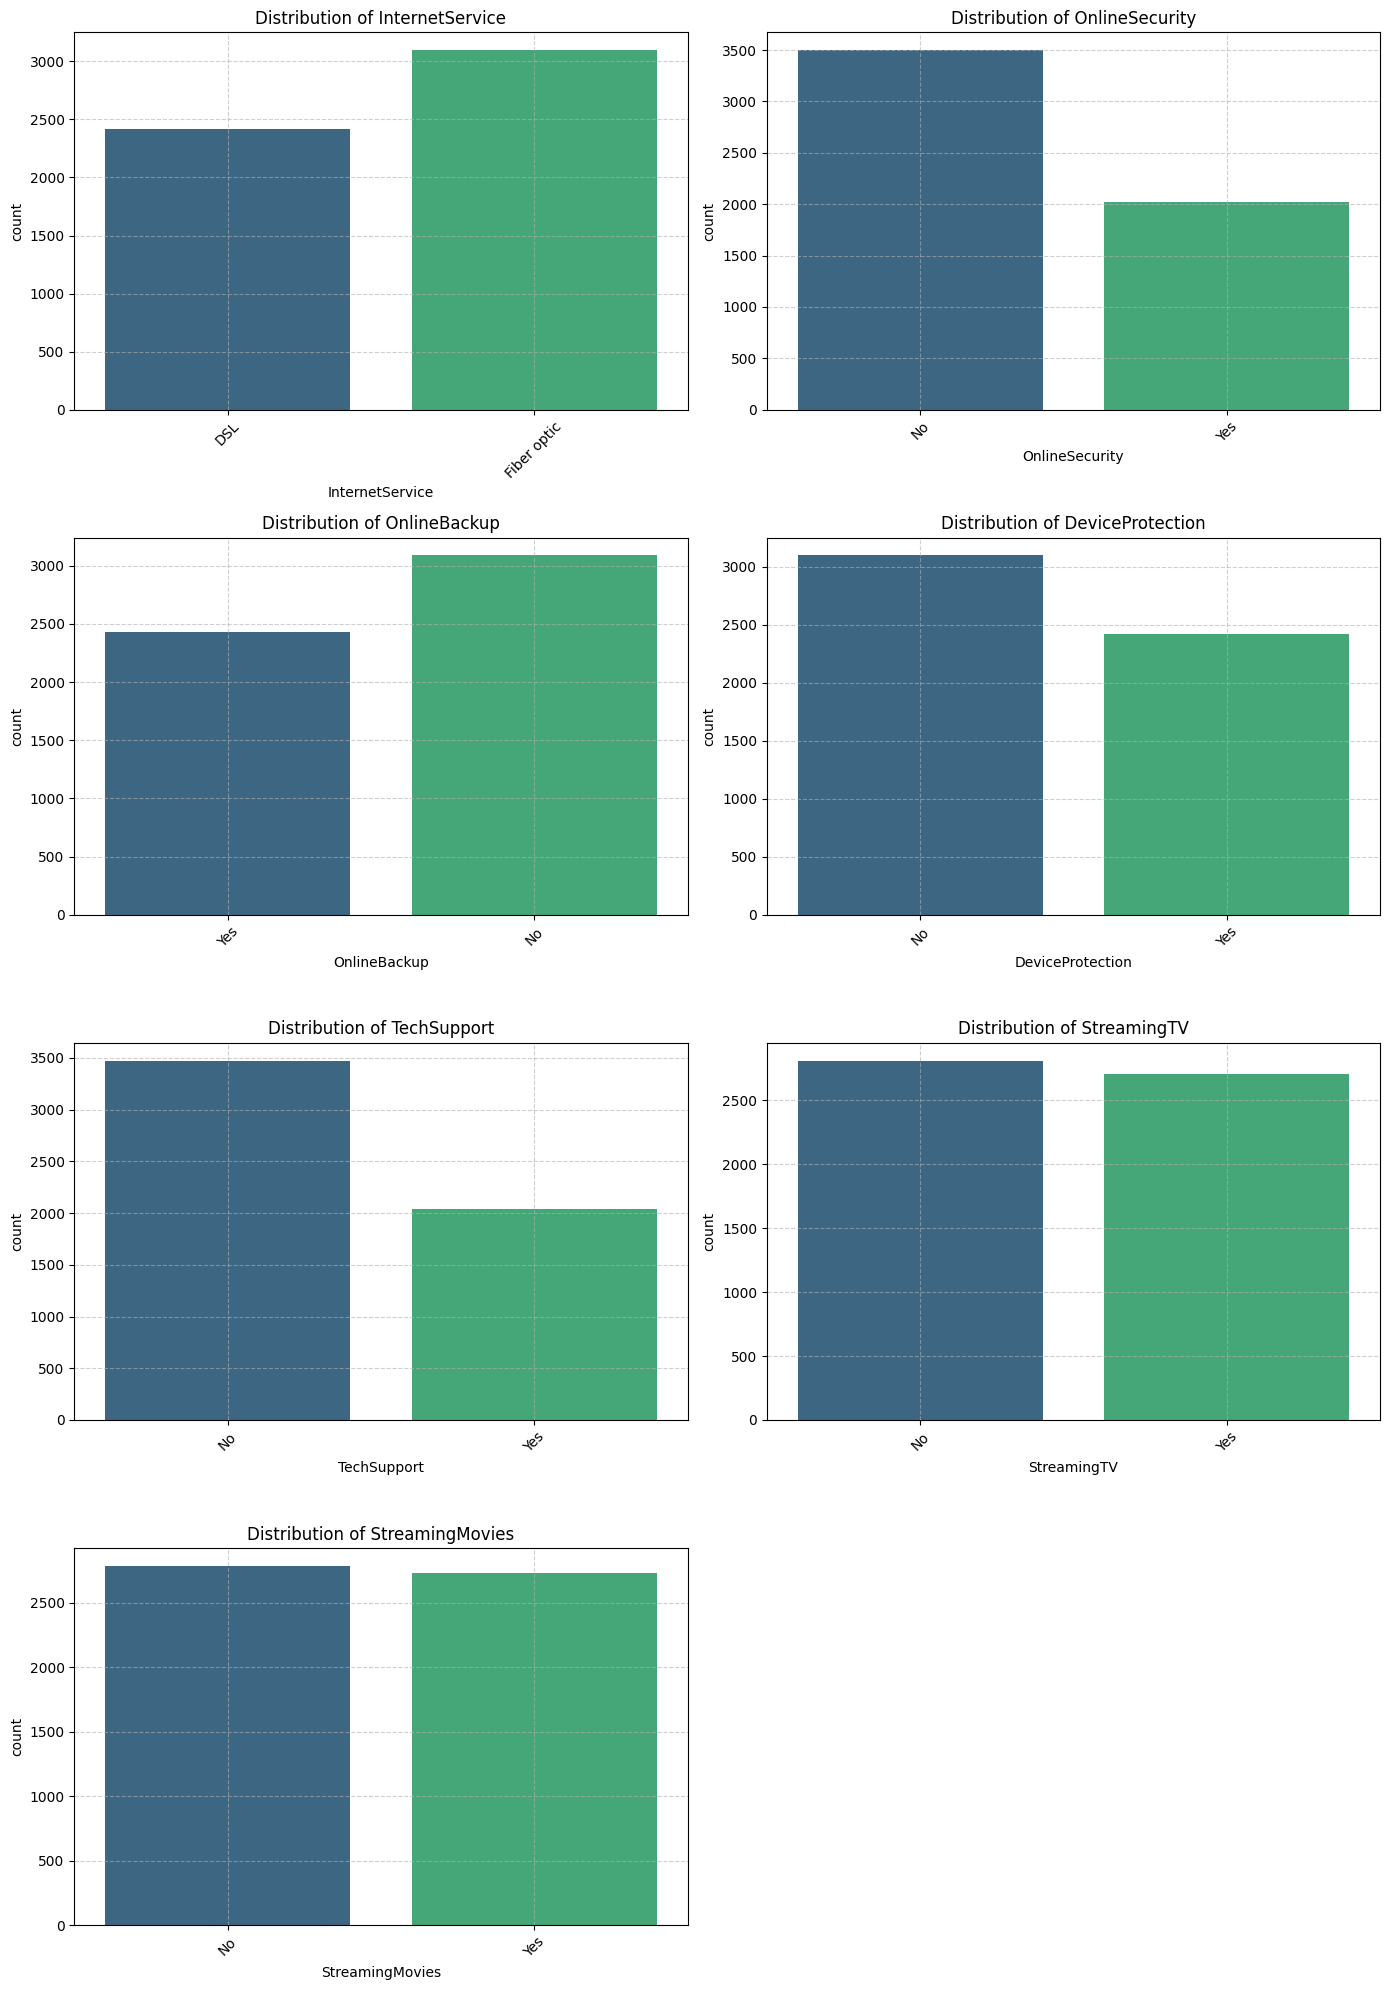

In [56]:
# Построим бар диаграммы
# Определяем столбцы для построения графиков
columns_to_plot = internet_df.columns[1:]  # Исключаем первый столбец (например, ID)
num_cols = len(columns_to_plot)

# Определяем количество строк для 2-х графиков в строке
num_rows = math.ceil(num_cols / 2)

# Создаем фигуру с сеткой 2 столбца на `num_rows` строк
fig, axes = plt.subplots(num_rows, 2, figsize=(14, num_rows * 5))

# Преобразуем массив осей в одномерный для удобной индексации
axes = axes.flatten()

# Создаем бар-диаграммы
for i, col in enumerate(columns_to_plot):
    sns.countplot(data=internet_df, x=col, hue=col, legend=False, palette="viridis", ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, linestyle="--", alpha=0.6)

# Удаляем пустые подграфики, если количество столбцов нечетное
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Оптимизация отображения
plt.tight_layout()
plt.show()

### Выводы

### Объединение таблиц по ID клиента

In [57]:
# Объединяем таблицы по 'customerID' (главная таблица - contract_df)
merged_df = contract_df \
    .merge(personal_df, on="CustomerID", how="left") \
    .merge(phone_df, on="CustomerID", how="left") \
    .merge(internet_df, on="CustomerID", how="left")

# Проверяем результат
merged_df.head()

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,ContractDuration,...,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,2020-01-01,2020-01-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,0,...,Yes,No,NaN,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,2017-04-01,2020-01-01,One year,No,Mailed check,56.95,2071.84,0,1005,...,No,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2019-10-01,2020-01-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,92,...,No,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-01-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,1340,...,No,No,NaN,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2019-09-01,2020-01-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,122,...,No,No,No,Fiber optic,No,No,No,No,No,No


In [58]:
merged_df.shape

(7043, 23)

In [59]:
merged_df['CustomerID'].duplicated().sum()

np.int64(0)

In [60]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Churn             7043 non-null   int64         
 9   ContractDuration  7043 non-null   int64         
 10  ContractCategory  7043 non-null   category      
 11  Gender            7043 non-null   object        
 12  SeniorCitizen     7043 non-null   int64         
 13  Partner           7043 non-null   object        
 14  Dependents        7043 n

In [61]:
# Проверяем количество пропусков
missing_values = merged_df.isnull().sum()
missing_values = missing_values[missing_values > 0]

# Вывод количества пропусков
print("Количество пропусков в каждом признаке:")
print(missing_values)

Количество пропусков в каждом признаке:
MultipleLines        682
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
dtype: int64


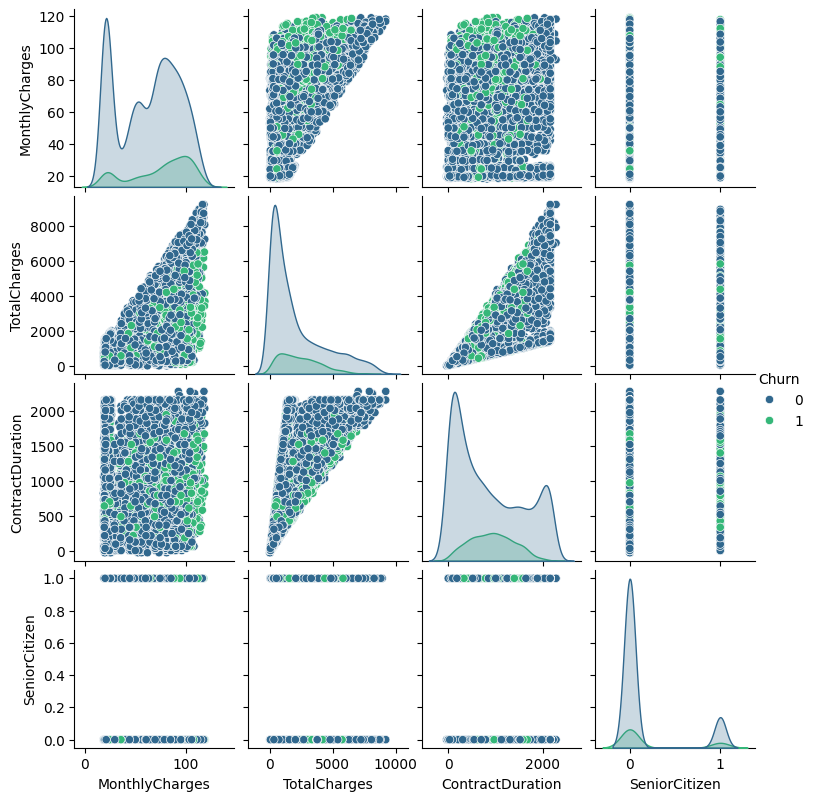

In [62]:
# Выбираем числовые признаки для анализа
selected_columns = ["MonthlyCharges", "TotalCharges", "ContractDuration",
                    "SeniorCitizen", "Churn"]

# Построение pairplot с hue по `Сhurn`
sns.pairplot(data=merged_df[selected_columns], hue="Churn", palette="viridis")

# Устанавливаем размер графика
plt.gcf().set_size_inches(8, 8)
plt.show()

In [63]:
# Определяем интервальные признаки (исключаем CustomerID)
interval_cols = merged_df.select_dtypes(include=["float64", "int64"]).columns.tolist()
if "CustomerID" in interval_cols:
    interval_cols.remove("CustomerID")

In [64]:
# Вычисляем phi_K корреляцию (без CustomerID)
phik_overview = merged_df.drop(columns=["CustomerID"]).phik_matrix(interval_cols=interval_cols)

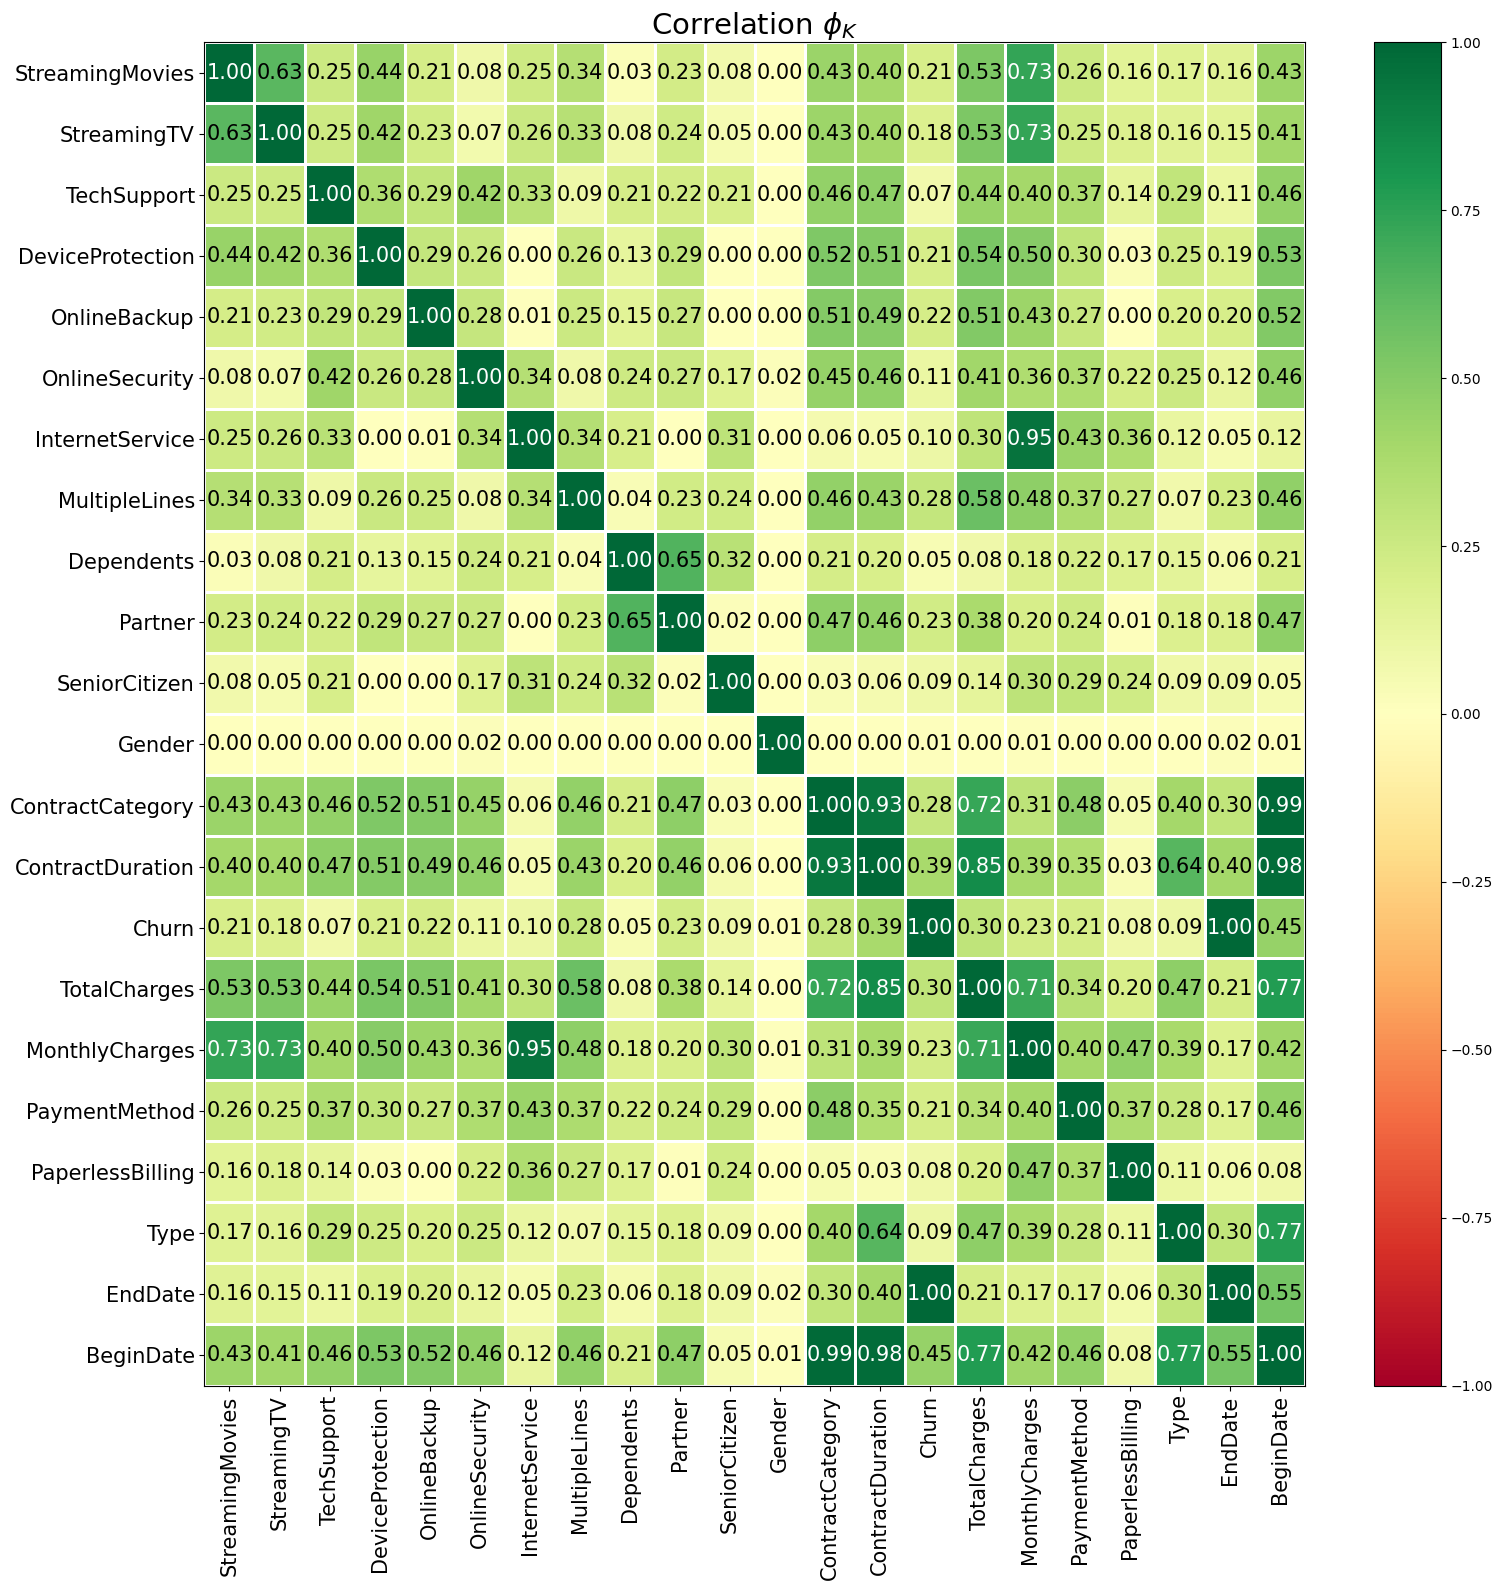

In [65]:
# Визуализация тепловой карты коэффициентов phi_K
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"Correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(16, 16)
)

#### Построим график корреляции признаков без гиперколлениарных признаков и дат

In [66]:
# Вычисляем phi_K корреляцию (без CustomerID)
phik_overview = merged_df.drop(columns=[
                                    "CustomerID", 
                                    "EndDate", 
                                    "ContractCategory",
                                    "BeginDate"
                                    ]).phik_matrix(interval_cols=interval_cols)

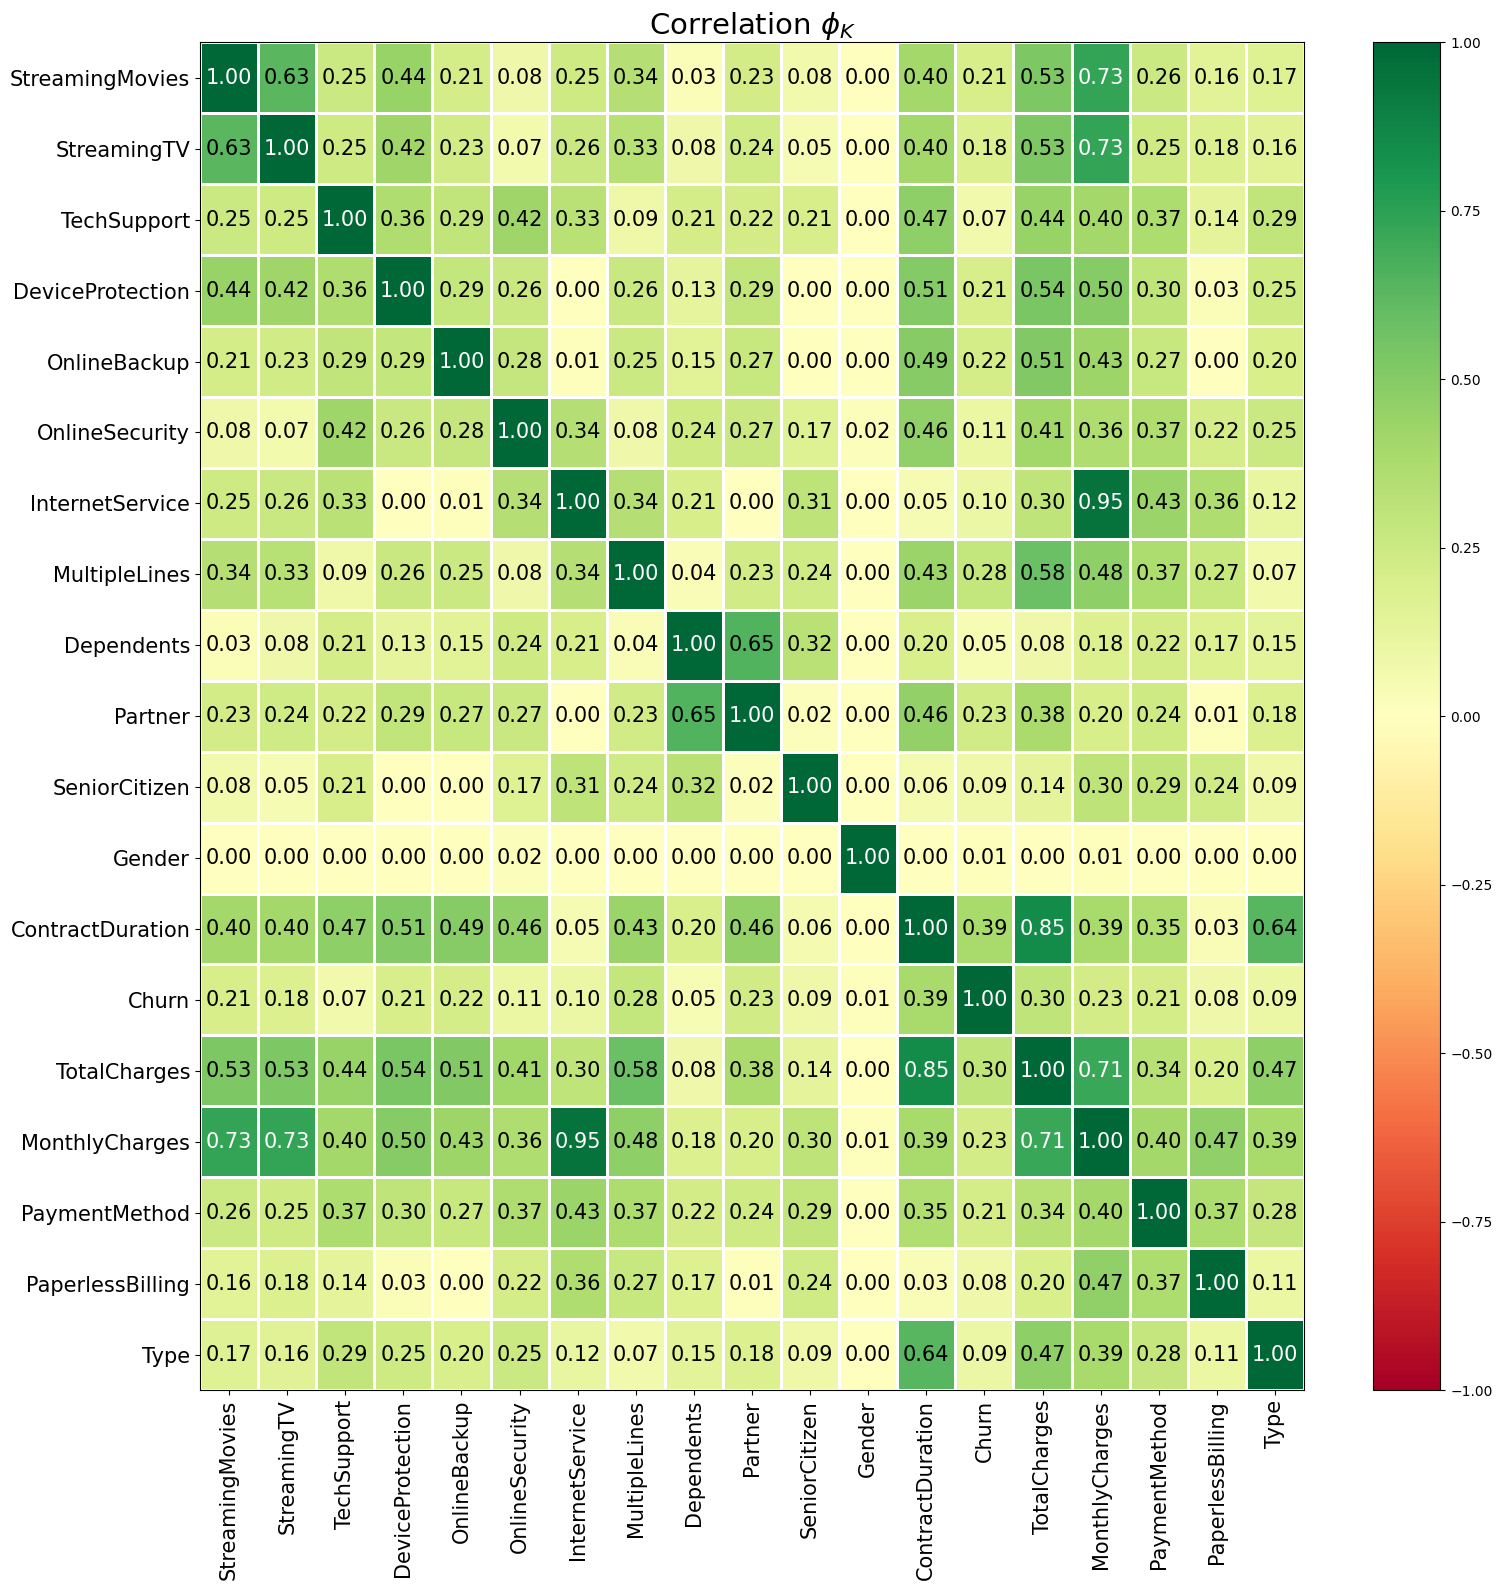

In [67]:
# Визуализация тепловой карты коэффициентов phi_K
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"Correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(16, 16)
)

### Выводы

### Подготовка данные для обучения

In [68]:
# Определим конечный датафрейм, который будеим использовать для обучения и тестирования
final_df = merged_df.drop(columns=[
                                    "CustomerID", 
                                    "EndDate", 
                                    "ContractCategory",
                                    "BeginDate"
                                    ])
final_df.shape

(7043, 19)

In [69]:
# Создадим тренировочную и тестовую выборки
X = final_df.drop('Churn', axis = 1)
y = final_df['Churn']

# Делим на тренировочную и тестовую выборки 
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=RANDOM_STATE, 
                                                    stratify=y)

# Проверяем размеры полученных выборок
print(f'Объем тренировочной выборки: {X_train.shape}')
print(f'Объем тестовой выборки: {X_test.shape}')

Объем тренировочной выборки: (5282, 18)
Объем тестовой выборки: (1761, 18)


In [70]:
# Делим тренировочную выборку на окончательную тренировочную (80%) и валидационную (20%)
X_sub_train, X_val, y_sub_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.2, 
                                                  random_state=42, 
                                                  stratify=y_train)

# Проверяем размеры выборок
print(f'Объем окончательной тренировочной выборки: {X_sub_train.shape}')
print(f'Объем валидационной выборки: {X_val.shape}')

Объем окончательной тренировочной выборки: (4225, 18)
Объем валидационной выборки: (1057, 18)


#### Подготовка числовых и категориальных признаков

In [71]:
# Выделяем числовые и категориальные признаки
num_features = ['MonthlyCharges', 'TotalCharges', 'ContractDuration']
cat_features = ['Type', 'PaperlessBilling', 'PaymentMethod', 'Partner', 'Gender', 'Dependents', 
                'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                'TechSupport', 'StreamingTV', 'StreamingMovies']

# Преобразование данных
num_transformer = StandardScaler()

cat_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

### Выбор моделей с гиперпараметрами

#### Random Forest

In [72]:
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

rf_params = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]
}

rf_grid = GridSearchCV(rf_pipeline, rf_params, cv=5, scoring='roc_auc', n_jobs=-1)

# Приводим y_sub_train к int (если нужно)
y_sub_train = y_sub_train.astype(int)

# Проверяем форму после трансформации
X_sub_train_transformed = preprocessor.fit_transform(X_sub_train)
print(f"Форма после трансформации: {X_sub_train_transformed.shape}")

# Запуск обучения
rf_grid.fit(X_sub_train, y_sub_train)

# Оценка на валидационной выборке
y_pred_rf = rf_grid.best_estimator_.predict(X_val)

print("Random Forest Best Params:", rf_grid.best_params_)
print("Random Forest Accuracy:", round(accuracy_score(y_val, y_pred_rf), 4))
print("Random Forest ROC AUC:", round(
    roc_auc_score(y_val, rf_grid.best_estimator_.predict_proba(X_val)[:, 1]), 4
))

Форма после трансформации: (4225, 42)
Random Forest Best Params: {'classifier__max_depth': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300}
Random Forest Accuracy: 0.8325
Random Forest ROC AUC: 0.8331


#### Gradient Boosting: XGBoost

In [73]:
# Инициализация списка для хранения лучших моделей
best_models = []

# Перебираем разные значения scale_pos_weight
for weight in [1.5, 2, 2.5, 3, 9.5, 10]:
    print(f"\n Testing scale_pos_weight={weight}")

    # Создаем XGBoost Pipeline с текущим весом классов
    xgb_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(eval_metric='logloss', max_delta_step=1, scale_pos_weight=weight))
    ])

    # Параметры для GridSearchCV
    xgb_params = {
        'classifier__n_estimators': [150, 250],
        'classifier__max_depth': [1, 3, 5],
        'classifier__learning_rate': [0.05, 0.1],
        'classifier__subsample': [0.8, 1.0],
        'classifier__colsample_bytree': [0.8, 1.0],
        'classifier__gamma': [0.2, 0.3],
        'classifier__reg_lambda': [1, 10]
    }

    # Запускаем GridSearchCV с текущим scale_pos_weight
    xgb_grid = GridSearchCV(xgb_pipeline, xgb_params, cv=5, scoring='roc_auc', n_jobs=-1)
    xgb_grid.fit(X_sub_train, y_sub_train)

    # Получаем предсказания на валидационной выборке
    y_pred_xgb_proba = xgb_grid.best_estimator_.predict_proba(X_val)[:, 1]
    y_pred_xgb = (y_pred_xgb_proba >= 0.5).astype(int)  # Бинаризация предсказаний

    # Вычисляем метрики
    roc_auc = roc_auc_score(y_val, y_pred_xgb_proba)
    accuracy = accuracy_score(y_val, y_pred_xgb)

    print(f" scale_pos_weight={weight}, Best ROC AUC: {roc_auc:.4f}, Accuracy: {accuracy:.4f}")

    # Сохраняем лучшие модели
    best_models.append((weight, xgb_grid.best_estimator_, roc_auc, accuracy))

# Выбираем лучший scale_pos_weight
best_weight, best_model, best_roc_auc, best_accuracy = max(best_models, key=lambda x: x[2])

# Получаем параметры XGBoost из best_model
best_xgb_params = best_model.named_steps['classifier'].get_params()

# Вывод лучших параметров XGBoost без префиксов
print(f"\n Best scale_pos_weight={best_weight} with ROC AUC={best_roc_auc:.4f}, Accuracy={best_accuracy:.4f}")
print(" Итоговые лучшие параметры XGBoost:")
for param, value in best_xgb_params.items():
    print(f"{param}: {value}")


 Testing scale_pos_weight=1.5
 scale_pos_weight=1.5, Best ROC AUC: 0.8791, Accuracy: 0.8827

 Testing scale_pos_weight=2
 scale_pos_weight=2, Best ROC AUC: 0.8811, Accuracy: 0.8751

 Testing scale_pos_weight=2.5
 scale_pos_weight=2.5, Best ROC AUC: 0.8764, Accuracy: 0.8770

 Testing scale_pos_weight=3
 scale_pos_weight=3, Best ROC AUC: 0.8738, Accuracy: 0.8666

 Testing scale_pos_weight=9.5
 scale_pos_weight=9.5, Best ROC AUC: 0.8740, Accuracy: 0.8335

 Testing scale_pos_weight=10
 scale_pos_weight=10, Best ROC AUC: 0.8745, Accuracy: 0.8212

 Best scale_pos_weight=2 with ROC AUC=0.8811, Accuracy=0.8751
 Итоговые лучшие параметры XGBoost:
objective: binary:logistic
base_score: None
booster: None
callbacks: None
colsample_bylevel: None
colsample_bynode: None
colsample_bytree: 0.8
device: None
early_stopping_rounds: None
enable_categorical: False
eval_metric: logloss
feature_types: None
gamma: 0.2
grow_policy: None
importance_type: None
interaction_constraints: None
learning_rate: 0.1
ma

#### Gradient Boosting: LGBMClassifier

In [74]:
from lightgbm import LGBMClassifier

# Вычисляем веса для классов
sample_weights = compute_sample_weight(class_weight='balanced', y=y_sub_train)

lgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(boosting_type='gbdt', random_state=42, verbose=-1))
])

# Гиперпараметры
lgb_params = {
    'classifier__n_estimators': [150, 250],
    'classifier__max_depth': [3, 6, 9],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0],
    'classifier__reg_lambda': [1, 10],
    'classifier__min_gain_to_split': [0.001, 0.01]
}

# GridSearch с передачей sample_weight
lgb_grid = GridSearchCV(lgb_pipeline, lgb_params, cv=5, scoring='roc_auc', n_jobs=-1)

# Передаём sample_weight в fit
lgb_grid.fit(X_sub_train, y_sub_train, classifier__sample_weight=sample_weights)

# Вывод результатов
print("LightGBM Best Params:", lgb_grid.best_params_)
print("LightGBM Accuracy:", round(accuracy_score(y_val, lgb_grid.best_estimator_.predict(X_val)), 4))
print("LightGBM ROC AUC:", round(roc_auc_score(y_val, lgb_grid.best_estimator_.predict_proba(X_val)[:, 1]), 4))

LightGBM Best Params: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 6, 'classifier__min_gain_to_split': 0.001, 'classifier__n_estimators': 250, 'classifier__reg_lambda': 1, 'classifier__subsample': 0.8}
LightGBM Accuracy: 0.8666
LightGBM ROC AUC: 0.8741


#### Нейронная сеть

# Определяем количество признаков после One-Hot Encoding
X_train_transformed = preprocessor.fit_transform(X_train)
input_dim = X_train_transformed.shape[1]  # Определяем корректное число признаков

# 3. Neural Network
def create_nn():
    model = Sequential([
        keras.layers.Input(shape=(input_dim,)),  # Задаем правильный input
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[keras.metrics.AUC()])
    return model

nn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KerasClassifier(build_fn=create_nn, epochs=10, batch_size=32, verbose=0, class_weight={0: 1, 1: 3}))
])

nn_pipeline.fit(X_sub_train, y_sub_train)

# Оценка нейросети
y_pred_nn_proba = nn_pipeline.predict_proba(X_val)[:, 1]  # Получаем вероятности класса 1
y_pred_nn = (y_pred_nn_proba >= 0.5).astype(int)  # Бинаризуем предсказания (если нужно)

# Вывод метрик
print("Neural Network ROC AUC:", round(roc_auc_score(y_val, y_pred_nn_proba), 4))
print("Neural Network Accuracy:", round(accuracy_score(y_val, y_pred_nn), 4))

#### Усложним нейронную сеть: увеличенное число нейронов (128 → 64 → 32), добавлен Batch Normalization, увеличим количество эпох

# 3. Neural Network
def create_nn():
    model = Sequential([
        keras.layers.Input(shape=(input_dim,)),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[keras.metrics.AUC()])
    return model

nn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KerasClassifier(build_fn=create_nn, epochs=50, batch_size=32, verbose=0, class_weight={0: 1, 1: 3}))
])

nn_pipeline.fit(X_sub_train, y_sub_train)
y_pred_nn_proba = nn_pipeline.predict_proba(X_val)[:, 1]
y_pred_nn = (y_pred_nn_proba >= 0.5).astype(int)
print("Neural Network ROC AUC:", round(roc_auc_score(y_val, y_pred_nn_proba), 4))
print("Neural Network Accuracy:", round(accuracy_score(y_val, y_pred_nn), 4))

# 3. Neural Network
from tensorflow.keras.utils import Sequence
import numpy as np

class BalancedDataGenerator(Sequence):
    def __init__(self, X, y, batch_size=32):
        self.X = np.array(X)  # Преобразуем в массив NumPy
        self.y = np.array(y)  # Преобразуем в массив NumPy
        self.batch_size = batch_size
        self.indices_0 = np.where(self.y == 0)[0]
        self.indices_1 = np.where(self.y == 1)[0]
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.y) / self.batch_size))

    def __getitem__(self, index):
        indices_0 = np.random.choice(self.indices_0, self.batch_size // 2, replace=True)
        indices_1 = np.random.choice(self.indices_1, self.batch_size // 2, replace=True)
        indices = np.concatenate([indices_0, indices_1])

        return self.X[indices], self.y[indices]  # Теперь всё работает!

    def on_epoch_end(self):
        np.random.shuffle(self.indices_0)
        np.random.shuffle(self.indices_1)

# Создаем генератор
train_gen = BalancedDataGenerator(X_sub_train_transformed, y_sub_train, batch_size=32)

# Преобразуем данные с помощью preprocessor
X_sub_train_transformed = preprocessor.fit_transform(X_sub_train)
X_val_transformed = preprocessor.transform(X_val)

# Создаем балансированный генератор
train_gen = BalancedDataGenerator(X_sub_train_transformed, y_sub_train, batch_size=32)

# Создаем модель
nn_model = create_nn()

# Коллбэки (если используешь)
callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)]

# Обучаем на генераторе
nn_model.fit(train_gen, epochs=50, validation_data=(X_val_transformed, y_val), callbacks=callbacks, verbose=1)

# Делаем предсказания
y_pred_nn_proba = nn_model.predict(X_val_transformed).flatten()
y_pred_nn = (y_pred_nn_proba >= 0.5).astype(int)

# Выводим метрики
print("Neural Network ROC AUC:", round(roc_auc_score(y_val, y_pred_nn_proba), 4))
print("Neural Network Accuracy:", round(accuracy_score(y_val, y_pred_nn), 4))

## Тестирование модели и демонстрация её работы

In [75]:
# Убираем 'eval_metric' и 'random_state', если они уже есть в best_xgb_params
best_xgb_params_clean = {k: v for k, v in best_xgb_params.items() if k not in ["eval_metric", "random_state"]}

# Создаем XGBoostClassifier с лучшими параметрами
final_xgb = XGBClassifier(eval_metric='logloss', random_state=42, **best_xgb_params_clean)

# Проверяем, что параметры совпадают
for param in best_xgb_params_clean:
    if best_xgb_params_clean[param] != final_xgb.get_params().get(param):
        print(f"⚠️ Несовпадение параметра: {param}")
    else:
        print(f"✔️ {param}: {best_xgb_params_clean[param]}")

✔️ objective: binary:logistic
✔️ base_score: None
✔️ booster: None
✔️ callbacks: None
✔️ colsample_bylevel: None
✔️ colsample_bynode: None
✔️ colsample_bytree: 0.8
✔️ device: None
✔️ early_stopping_rounds: None
✔️ enable_categorical: False
✔️ feature_types: None
✔️ gamma: 0.2
✔️ grow_policy: None
✔️ importance_type: None
✔️ interaction_constraints: None
✔️ learning_rate: 0.1
✔️ max_bin: None
✔️ max_cat_threshold: None
✔️ max_cat_to_onehot: None
✔️ max_delta_step: 1
✔️ max_depth: 5
✔️ max_leaves: None
✔️ min_child_weight: None
⚠️ Несовпадение параметра: missing
✔️ monotone_constraints: None
✔️ multi_strategy: None
✔️ n_estimators: 250
✔️ n_jobs: None
✔️ num_parallel_tree: None
✔️ reg_alpha: None
✔️ reg_lambda: 1
✔️ sampling_method: None
✔️ scale_pos_weight: 2
✔️ subsample: 1.0
✔️ tree_method: None
✔️ validate_parameters: None
✔️ verbosity: None


In [76]:
# Берем только лучшие параметры XGBoost
best_xgb_params = best_model.named_steps['classifier'].get_params()

# Убираем префикс 'classifier__' из названий параметров
clean_xgb_params = {k.split('__')[1]: v for k, v in best_xgb_params.items() if 'classifier__' in k}

# Создаем XGBoostClassifier с лучшими параметрами
final_xgb = XGBClassifier(eval_metric='logloss', **clean_xgb_params, random_state=42)

In [77]:
# Преобразуем полную тренировочную выборку
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Обучаем модель на полной тренировочной выборке
final_xgb.fit(X_train_transformed, y_train);

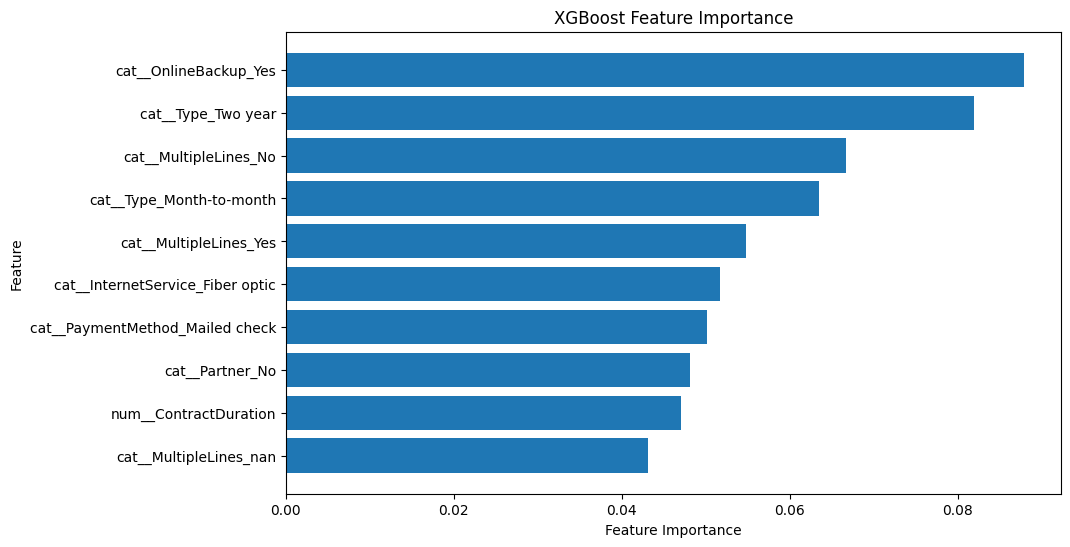

                                       Feature  Importance
28                       cat__OnlineBackup_Yes    0.087903
5                           cat__Type_Two year    0.081997
18                       cat__MultipleLines_No    0.066715
3                     cat__Type_Month-to-month    0.063551
19                      cat__MultipleLines_Yes    0.054755
22            cat__InternetService_Fiber optic    0.051737
11             cat__PaymentMethod_Mailed check    0.050166
12                             cat__Partner_No    0.048112
2                        num__ContractDuration    0.047059
20                      cat__MultipleLines_nan    0.043089
40                    cat__StreamingMovies_Yes    0.033921
31                   cat__DeviceProtection_Yes    0.027071
0                          num__MonthlyCharges    0.025162
30                    cat__DeviceProtection_No    0.024671
27                        cat__OnlineBackup_No    0.024387
16                          cat__Dependents_No    0.0230

In [78]:
# Получаем важность признаков
feature_importance = final_xgb.feature_importances_
feature_names = preprocessor.get_feature_names_out()

# Создаем DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# Сортируем по убыванию важности
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Визуализируем ТОП-10 признаков
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["Feature"][:10], feature_importance_df["Importance"][:10])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()
plt.show()

# Выводим топ-20 признаков в консоли
print(feature_importance_df.head(20))

In [79]:
# Предсказания на тестовой выборке
y_pred_test_proba = final_xgb.predict_proba(X_test_transformed)[:, 1]
y_pred_test = (y_pred_test_proba >= 0.5).astype(int)

# Оцениваем результаты
roc_auc_test = roc_auc_score(y_test, y_pred_test_proba)
accuracy_test = accuracy_score(y_test, y_pred_test)

# Выводим результаты
print(f" Final Model Evaluation on Test Set")
print(f" ROC AUC: {roc_auc:.4f}")
print(f" Accuracy: {accuracy:.4f}")

 Final Model Evaluation on Test Set
 ROC AUC: 0.8745
 Accuracy: 0.8212
